# Flow diagram for scraping and storing google schloar data using SerpAPI

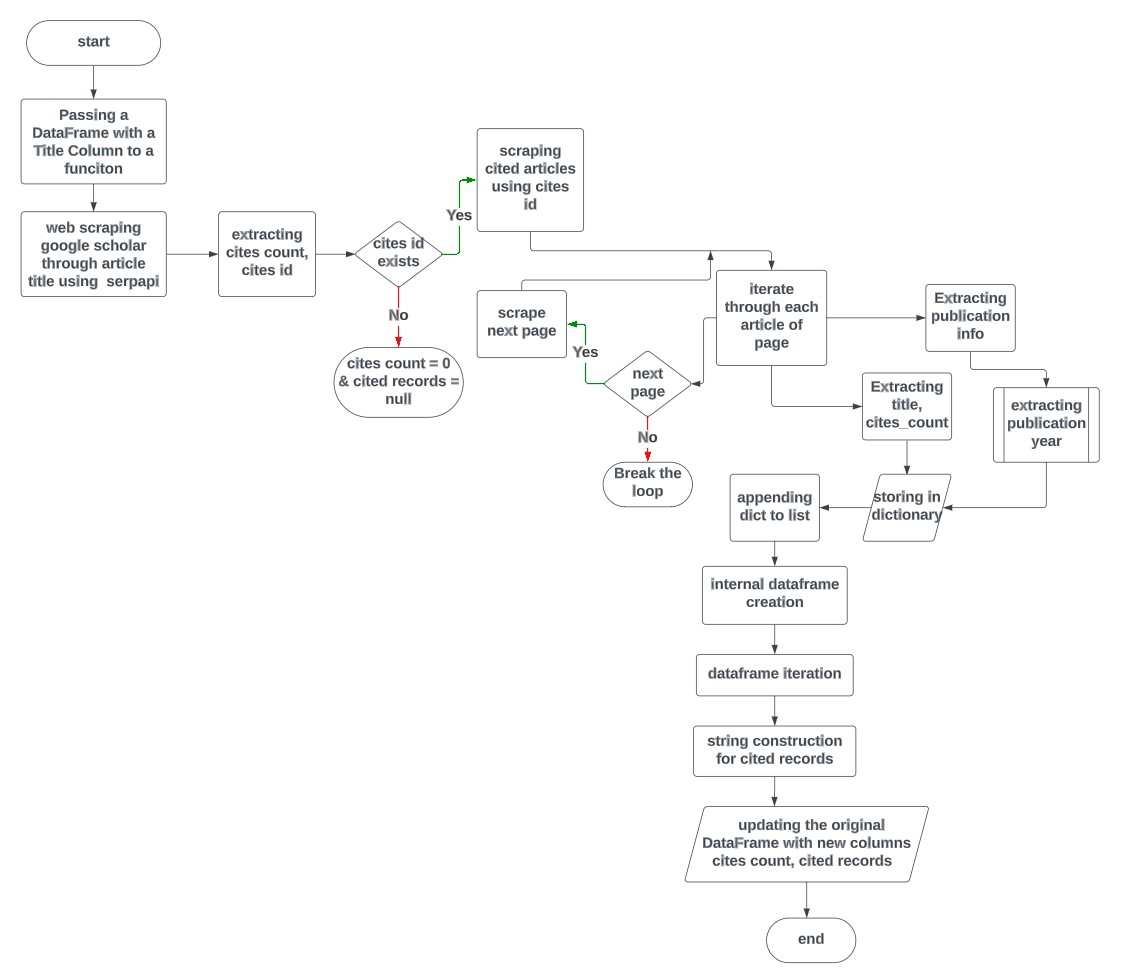

#  Code for illustrating the sample extraction of citation data from google scholar 

In [1]:
import pandas as pd

In [2]:
df_cites = pd.read_excel('data_l2\citations_L2.xlsx',sheet_name='Sheet1')
df_cites = df_cites[5:15]
df_cites

,Paper ID,Title,Cited by
5,P1440,The Effect of Multiple Scopus Profiles on the ...,0
6,P1439,Neurosurgical Academic Impact Rankings by h5-I...,0
7,P1438,Knowledge Mapping of Intracranial Aneurysm Cli...,0
8,P1437,Academic Productivity of Neurosurgeons Practic...,0
9,P1436,Analysis of Factors That Influence Academic Pr...,1
10,P1435,h-Index Five Years On: Academic Impact Ranking...,1
11,P1434,Scholarly Collaboration Networks: Theory and F...,1
12,P1433,Commerce Versus Science: A Perpetual Dialectic,1
13,P1432,The Impact of Specialization in Journal Networ...,3
14,P1431,Research productivity and fellowship training ...,3


In [3]:
## calling cited_recs() by passing df with a column of title names will return the dataframe by updating new columns with GS_citation_count and cited_records

# code to get the cites id of article by providing article title as a query
# Import the required library or module to perform the search
from serpapi import GoogleSearch                # library for interacting with the SerpApi service
from urllib.parse import urlsplit, parse_qsl    # used for parsing URLs
import pandas as pd
import os, json

api_key = "e29f4e01a656f23216e99abaad17126658af11f79468c725a094f579bd7762f5"
# Define the function that extracts the citation IDs of an article based on a given query. (title)
def article_cites_id(query):
    # Set up the parameters  
    params = {
        "engine": "google_scholar", # search using the Google Scholar engine
        "q": query,        # The 'query' parameter will be used to specify the article title or keywords
        "hl": "en",        # 'hl' stands for 'host language' and sets the language of the search results to English
        "api_key": api_key      # 'api_key' is a variable that should be defined with actual API key for Google Scholar
    }

    # Create a GoogleSearch object with the specified parameters
    search = GoogleSearch(params)

#     # Initialize lists to store the data
#     organic_results_data = [] # This list will store information about the search results (not used in this code)
#     cites_ids = [] # This list will store the citation IDs of the article (if any)

    # Get the 'organic_results' of search results as a dictionary
    results = search.get_dict()['organic_results']

    # Get the first result (most relevant) from the search results and store in result
    result = results[0]

    # Print a message indicating the extraction of citation IDs for the article
    print(f"Extracting cites_id of article: {result.get('title')} ")

    # Try to extract the total count of citations for the article (if available)
    # If not available, set the count to 0
    try:
        cites_count = int(result["inline_links"]["cited_by"]["total"])
    except:
        cites_count = 0

    # Try to extract the citation IDs of the article (if available)
    # If not available, set the 'cites_id' variable to None  (cited articles dosen't exist)
    try:
        cites_id = result['inline_links']['cited_by']['cites_id']
    except:
        cites_id = None

    # Return the citation IDs and the count of citations
    return cites_id, cites_count



# code to get the cited articles of data by providing cites id of article

# Import the required library or module to perform the search
from serpapi import GoogleSearch          # library for interacting with the SerpApi service
from urllib.parse import urlsplit, parse_qsl   # used for parsing URLs
import pandas as pd
import os, json

# Define the function that scrapes information about cited articles based on given cites_ID of article
def scrape_cited_articles_by_article(cites_id):
    # Set up the parameters for the search 
    params = {
        "api_key": api_key,        # The 'api_key' parameter should be defined with our actual API key for the serpapi service
        "engine": "google_scholar",  # using the Google Scholar engine
        "cites": cites_id,   # 'cites' specifies the cites_ID to retrieve information about
        "hl": "en",         # 'hl' stands for 'host language' and sets the language of the search results to English
        "num": "20",        # 'num' sets the number of search results to fetch per request (here, 20 results per request)
    }

    # Create a GoogleSearch object with the specified parameters
    search = GoogleSearch(params)

    # Initialize a list to store the data of cited articles
    organic_results_data = []

    # Start a loop to keep fetching search results until there are no more 'next' pages
    while True:
        # Get the search results as a dictionary
        results = search.get_dict()

        # Iterate over each result in the search results
        for result in results.get("organic_results", {}):
            # Print a message indicating the extraction of information about the specific cited article 
            print(f"Extracting cited_article: {result.get('title')} ")
            position = result.get("position")  
            title = result.get("title")          # extracting title of cited article
            publication_info_summary = result.get("publication_info", {}).get("summary")  # extracting publication info
            result_id = result["result_id"]

            # Extract the publication year from the publication information summary(if available) by calling a function
            try:
                publication_year = int(get_last_four_digits(publication_info_summary))
            except:
                publication_year = None

            # Try to extract the total count of citations for the cited article (if available)
            # If not available, set the count to 0
            try:
                cited_by_count = int(result["inline_links"]["cited_by"]["total"])
            except:
                cited_by_count = None

            # Append the extracted information to the 'organic_results_data' list as a dictionary
            organic_results_data.append({  
                "Publication_year": publication_year,   
                "Cited_by_count": cited_by_count,
                "Title": title,
            })

        # Check if there is a 'next' page in the search results
        if "next" in results.get("serpapi_pagination", {}):
            # Update the search parameters to fetch the next page of results
            search.params_dict.update(dict(parse_qsl(urlsplit(results["serpapi_pagination"]["next"]).query)))
        else:
            # If there is no 'next' page, break out of the loop
            break

    # Print the scraped data in a pretty-printed JSON format and the number of total extracted cited articles
    print(json.dumps(organic_results_data, indent=1, ensure_ascii=False))
    print(f"Done. Extracted {len(organic_results_data)} articles.") # counts 
    print('*--------*')

    # Convert the scraped data into a Pandas DataFrame 
    df = pd.DataFrame(data=organic_results_data)

    # Create a string containing the information of all the cited articles for easier output
    cited_rec = ''
    for _, row in df.iterrows():   # iterate through each row of df
        row_str = ', '.join(str(value) for value in row)    #adding each value of row to a string seperating by ','
        cited_rec += row_str + '; '                        # seperating each cited article by '; '
    cited_rec

    # Return the string containing the information of cited articles
    return cited_rec


# Define the function that extracts the last four digits from a given string
def get_last_four_digits(string):
    digits = []           # Initialize an empty list digits to store the digits
    # Split the input string using ' - '  and consider the second part of the split
    # Iterate over each character in the second part of the split string
    for char in string.split(' - ')[1]:
        # Check if the character is a digit
        if char.isdigit():
            # If it's a digit, append it to the 'digits' list
            digits.append(char)
        else:
            # If it's not a digit, reset the 'digits' list (to handle cases where digits are not continuous)
            digits = []
    # Join the digits list to form a single string and return the last four digits
    return ''.join(digits)


# Define the function that retrieves cited records for an article based on its title
def article_cited_recs(q):
    # Print the title of the article being searched for
    print('Title: ', q)
    # Get the cites_id and count of citations for the article using the 'article_cites_id' function
    cites_id, cites_count = article_cites_id(q)
    # Scrape information about cited articles using the 'scrape_cited_articles_by_article' function
    cited_recs = scrape_cited_articles_by_article(cites_id)
    # Return the count of citations and the string containing the information of cited articles
    return cites_count, cited_recs

# Define the function that retrieves cited records for each article in a DataFrame
def cited_recs(df):
    # Add two new columns to the DataFrame to store the Google Scholar citations count and the citation records
    df['Google Scholar Citations'] = None
    df['Citations records'] = None
    # Iterate over each row in the DataFrame
    for index, row in df.iterrows():
        # Call the 'article_cited_recs' function to get the count of citations and cited records for the current article
        citations, citation_recs = article_cited_recs(row['Title'])
        
        # Update the 'Google Scholar Citations' column in the DataFrame with the count of citations
        df.at[index, 'Google Scholar Citations'] = citations
        
        # Update the 'Citations records' column in the DataFrame with the string containing the information of cited articles
        df.at[index, 'Citations records'] = citation_recs

    # Return the updated DataFrame with additional columns for citations and cited records
    return df


In [4]:
cited_recs(df_cites)

Title:  The Effect of Multiple Scopus Profiles on the Perceived Academic Productivity of Neurosurgeons in the United States
Extracting cites_id of article: The Effect of Multiple Scopus Profiles on the Perceived Academic Productivity of Neurosurgeons in the United States 
[]
Done. Extracted 0 articles.
*--------*
Title:  Neurosurgical Academic Impact Rankings by h5-Index: A Global Perspective
Extracting cites_id of article: Neurosurgical Academic Impact Rankings by h5-Index: A Global Perspective 
[]
Done. Extracted 0 articles.
*--------*
Title:  Knowledge Mapping of Intracranial Aneurysm Clipping: A Bibliometric and Visualized Study (2001-2021)
Extracting cites_id of article: Knowledge Mapping of Intracranial Aneurysm Clipping: A Bibliometric and Visualized Study (2001–2021) 
[]
Done. Extracted 0 articles.
*--------*
Title:  Academic Productivity of Neurosurgeons Practicing in Joint Residency Advisory and Accreditation Committee Accredited Programs
Extracting cites_id of article: Acade

,Paper ID,Title,Cited by,Google Scholar Citations,Citations records
5,P1440,The Effect of Multiple Scopus Profiles on the ...,0,0,
6,P1439,Neurosurgical Academic Impact Rankings by h5-I...,0,0,
7,P1438,Knowledge Mapping of Intracranial Aneurysm Cli...,0,0,
8,P1437,Academic Productivity of Neurosurgeons Practic...,0,0,
9,P1436,Analysis of Factors That Influence Academic Pr...,1,3,"2023, None, Geographic Distribution in Trainin..."
10,P1435,h-Index Five Years On: Academic Impact Ranking...,1,1,"2023, None, Neurosurgical Academic Impact Rank..."
11,P1434,Scholarly Collaboration Networks: Theory and F...,1,2,"2021, 11, Group-oriented paper recommendation ..."
12,P1433,Commerce Versus Science: A Perpetual Dialectic,1,1,"2017, 13, Altmetrics in scientific research: f..."
13,P1432,The Impact of Specialization in Journal Networ...,3,4,"2022, nan, The Author Impact Factor as a Metri..."
14,P1431,Research productivity and fellowship training ...,3,4,"2019, 24.0, Comprehensive Researcher Achieveme..."


In [5]:
df_cites

,Paper ID,Title,Cited by,Google Scholar Citations,Citations records
5,P1440,The Effect of Multiple Scopus Profiles on the ...,0,0,
6,P1439,Neurosurgical Academic Impact Rankings by h5-I...,0,0,
7,P1438,Knowledge Mapping of Intracranial Aneurysm Cli...,0,0,
8,P1437,Academic Productivity of Neurosurgeons Practic...,0,0,
9,P1436,Analysis of Factors That Influence Academic Pr...,1,3,"2023, None, Geographic Distribution in Trainin..."
10,P1435,h-Index Five Years On: Academic Impact Ranking...,1,1,"2023, None, Neurosurgical Academic Impact Rank..."
11,P1434,Scholarly Collaboration Networks: Theory and F...,1,2,"2021, 11, Group-oriented paper recommendation ..."
12,P1433,Commerce Versus Science: A Perpetual Dialectic,1,1,"2017, 13, Altmetrics in scientific research: f..."
13,P1432,The Impact of Specialization in Journal Networ...,3,4,"2022, nan, The Author Impact Factor as a Metri..."
14,P1431,Research productivity and fellowship training ...,3,4,"2019, 24.0, Comprehensive Researcher Achieveme..."
